### To do:  
#### PREPARING DATA: Normalize continuous data (look back at all the features!!)
#### CHOOSE A BASELINE: for example, prediction=last disease stage
#### MAKE YOUR MODEL OVERFIT (MORE EPOCHS, MORE UNITS...)
#### THEN HYPERPARAMETER TUNING, REGULARISATION & EVENTUALLY ITERATE WITH FEATURES ENGINEERING (REDUCING NUMBER OF FEATURES)

> Read Advances techniques in Keras of F.chollet before starting...

### Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
% matplotlib inline

## 1. Data Pre-Processing

In [107]:
### reading processed dataframe
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head(2)

,PATNO,EVENT_ID,INFODT,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,SC,02/2011,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,V04,03/2012,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,...,0,0,2,7,2,394,2313,700,0,0


### Selection only patients with more than one visit 

In [108]:
df_2visits=df[df.num_visits>=2]
print(len(df_2visits)/len(df))
print('samples lost: {}'.format((df.shape[0]-df_2visits.shape[0])))
assert len(df_2visits[df_2visits['num_visits']==1])==0

0.8597408026755853
samples lost: 671


### Padding visit sequences for a sequence_length=4 - custom function TO CORRECT

In [119]:
subdf=df_2visits[df_2visits['num_visits']==2]
rowstoAdd=subdf.groupby('PATNO').median()
rowstoAdd[Engineered_features_max]=subdf.groupby('PATNO').max()[Engineered_features_max]
rowstoAdd[Engineered_features_min]=subdf.groupby('PATNO').min()[Engineered_features_min]
rowstoAdd.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3006,0.0,0.0,0.5,1.0,0.0,0.0,2.5,0.0,1.0,1.0,...,0.0,0.0,2.0,2.0,1.5,213.5,2252,547,0,0
3022,0.5,0.0,1.5,1.5,0.5,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,2.0,2.0,1.5,228.0,1826,516,0,0
3024,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,1.0,...,0.0,0.0,2.0,2.0,1.5,228.5,1795,547,0,0
3129,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1.0,0.5,0.0,...,1.0,0.0,1.0,2.0,1.5,197.5,1734,579,0,0
3253,0.0,0.0,0.5,0.5,0.5,0.0,0.0,1.5,0.0,1.0,...,0.0,0.0,2.0,2.0,1.5,213.5,2342,457,0,0


In [116]:
t=subdf.groupby('PATNO').min()[Engineered_features_min]

In [118]:
t.head()

PATNO
3006    2252
3022    1826
3024    1795
3129    1734
3253    2342
Name: lastDate_diff_days, dtype: int64

In [125]:
def rows_to_pad(df, num_visits, visit_ID):
    subdf=df[df['num_visits']==num_visits]
    rowstoAdd=subdf.groupby('PATNO').median() 

    # Changing the value of the engineered features
    Engineered_features_max=['PDDXDT_diff_days','PDMEDT_diff_days','PDSURGDT_diff_days']
    Engineered_features_min='lastDate_diff_days'
    rowstoAdd[Engineered_features_max]=subdf.groupby('PATNO').max()[Engineered_features_max]
    rowstoAdd[Engineered_features_min]=subdf.groupby('PATNO').min()[Engineered_features_min]
    rowstoAdd['VISIT_ID']=visit_ID
    rowstoAdd['visitsdiff_days']=3*61 # we assume that the visit we add is three months later

    # updating the engineered values features
    rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
    rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                     rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
    maskMED=rowstoAdd['PDMEDT_diff_days']!=0
    rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
    maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
    rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']
    
    return rowstoAdd

def padding_visits_PPMI(df, seq_length=4):

    #number of visits==2
    ## Visit_ID=3
    rowstoAdd=rows_to_pad(df,num_visits=2,visit_ID=3)
    
    #Number of visits==2
    ##Visit_ID==4
    rowstoAdd2=rows_to_pad(df,num_visits=2,visit_ID=4)
    
    #Number of visits==3, visit_ID=4
    rowstoAdd3=rows_to_pad(df,num_visits=3,visit_ID=4)

    # concatenating all the rows to add
    rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rowstoAdd3])
    rowspadding['num_visits']=4
    rowspadding.reset_index(inplace=True)
    #print(rowspadding.shape)

    # reformatting final df
    dfpad_th4=df.drop(columns=['INFODT_date','INFODT','EVENT_ID'])
    dfpad_th4=pd.concat([dfpad_th4,rowspadding])
    # updating the new number of visits for the padded sequences
    dfpad_th4['num_visits'].replace(2,4,inplace=True)
    dfpad_th4['num_visits'].replace(3,4,inplace=True)
    dfpad_th4.reset_index(drop=True,inplace=True)
    dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0)) 
    # APPLY ROUND TO ALL VARIABLE INSTEAD?
    dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
    print('df final shape: {}'.format(dfpad_th4.shape))
    print('number final of patients:{}'.format(len(set(dfpad_th4['PATNO']))))
    
    return dfpad_th4

In [126]:
df_4visits=padding_visits_PPMI(df_2visits)

df final shape: (4887, 375)
number final of patients:1003


In [130]:
df_4visits.head()

,PATNO,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,1,0,2707,306,0,0
1,3001,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,2,394,2313,700,0,0
2,3001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,3,426,1887,1126,0,0
3,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,4,335,1552,1461,0,0
4,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,7,5,365,1187,1826,0,0


In [131]:
from keras.preprocessing.sequence import pad_sequences
# caution: to pad/trucate sequences, you need to reshape your data first
cols=list(df_4visits.columns)
cols.remove('PATNO')
df_reshaped=pd.DataFrame()
for col in cols:
    ser_col=df_4visits.groupby('PATNO')[col].apply(list)
    keys=list(df.columns).append(col)
    df_reshaped=pd.concat([df_reshaped,ser_col],axis=1,keys=keys)

df_reshaped.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[7, 7, 7, 7, 7, 7, 7]","[1, 2, 3, 4, 5, 6, 7]","[0, 394, 426, 335, 365, 427, 638]","[2707, 2313, 1887, 1552, 1187, 760, 122]","[306, 700, 1126, 1461, 1826, 2253, 2891]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
3002,"[1.0, 1.0, 2.0, 1.0, 2.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 1.0, 3.0, 0.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 2.0, 1.0, 1.0]","[0.0, 0.0, 2.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 2.0, 1.0, 2.0, 0.0, 2.0]","[0.0, 2.0, 1.0, 3.0, 3.0, 3.0]","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 2.0, 1.0, 1.0, 2.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[6, 6, 6, 6, 6, 6]","[1, 2, 3, 4, 5, 6]","[0, 397, 365, 699, 397, 730]","[2679, 2282, 1917, 1218, 821, 91]","[393, 790, 1155, 1854, 2251, 2981]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]"
3003,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[7, 7, 7, 7, 7, 7, 7]","[1, 2, 3, 4, 5, 6, 7]","[0, 397, 365, 365, 365, 366, 365]","[2679, 2282, 1917, 1552, 1187, 821, 456]","[730, 1127, 1492, 1857, 2222, 2588, 2953]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
3006,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.5, 0.5]","[1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[2.0, 3.0, 2.5, 2.5]","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0]","[4, 4, 4, 4]","[1, 2, 3, 4]","[0, 427, 183, 183]","[2679, 2252, 2069, 2069]","[120, 547, 730, 730]","[0, 0, 0, 0]","[0, 0, 0, 0]"
3010,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 1.0, 0.0, 3.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 2.0, 2.0, 1.0, 2.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 2.0, 3.0, 2.0, 2.0, 3.0]","[1.0, 2.0, 3.0, 2.0, 2.0, 3.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 1.0, 2.0, 2.0, 1.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[6, 6, 6, 6, 6, 6]","[1, 2, 3, 4, 5, 6]","[30, 397, 395, 427, 273, 519]","[2618, 2221, 1826, 1399, 1126, 607]","[89, 486, 881, 1308, 1581, 2100]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]"


In [177]:
target=df_reshaped['NHY']
data=df_reshaped.values

target_truncated=pad_sequences(target,maxlen=4)
target_final=target_truncated[:,3]
#target_final.reshape((target_final.shape[0],1))
target_final.shape

(1003,)

In [178]:
data_truncated=np.zeros(shape=(data.shape[0],data.shape[1],3),dtype=int)
for i in range(data.shape[1]):
    # take the last 4 sequences
    seq_truncated_col=pad_sequences(data[:,i],maxlen=4)
    # remove the last sequence (visit to predict)
    seq_truncated_col=pad_sequences(seq_truncated_col,maxlen=3,truncating='post')
    data_truncated[:,i]=seq_truncated_col
data_truncated[0]

array([[   0,    0,    1],
       [   0,    0,    0],
       [   0,    0,    1],
       ...,
       [1461, 1826, 2253],
       [   0,    0,    0],
       [   0,    0,    0]])

In [179]:
print(data_truncated.shape)
data_final=np.transpose(data_truncated,axes=(0,2,1))
data_final.shape # final data shape: (num_of_samples, number_of_timesteps, number of features)

(1003, 374, 3)


(1003, 3, 374)

In [170]:
set(target_final)

{0, 1, 2, 3, 4, 5}

## 2. Split the dataset train/test/val

In [180]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.cross_validation as cv

In [181]:
from keras.utils import to_categorical
target_final=to_categorical(target_final,num_classes=6,dtype='int32')
print(target_final.shape)
target_final[:2]

(1003, 6)


array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=int32)

In [182]:
X_train, X_test=train_test_split(data_final, test_size=0.2, random_state=0)
y_train, y_test=train_test_split(target_final, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(802, 3, 374)
(201, 3, 374)
(802, 6)


## 3. LSTM model (simple vanilla LSTM model)

In [183]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

### Defining and compiling the model

In [184]:
n_class=6
seq_length=3
n_features=374

### hyperparameters to optimize
optimizer='adam'
input_units=25
n_epochs=10
batch_size=32

model=Sequential()
model.add(LSTM(25, input_shape=(seq_length,n_features)))
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 25)                40000     
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 156       
Total params: 40,156
Trainable params: 40,156
Non-trainable params: 0
_________________________________________________________________
None


### fit the model

In [185]:
history=model.fit(X_train, y_train, batch_size=batch_size,epochs=n_epochs,validation_split=0.2)

Train on 641 samples, validate on 161 samples
Epoch 1/10
641/641 [==============================] - 2s 3ms/step - loss: 1.5830 - acc: 0.4711 - val_loss: 1.2507 - val_acc: 0.7019
Epoch 2/10
641/641 [==============================] - 0s 291us/step - loss: 1.1817 - acc: 0.7551 - val_loss: 1.0814 - val_acc: 0.7764
Epoch 3/10
641/641 [==============================] - 0s 307us/step - loss: 1.0779 - acc: 0.7769 - val_loss: 1.0153 - val_acc: 0.7888
Epoch 4/10
641/641 [==============================] - 0s 297us/step - loss: 1.0212 - acc: 0.7769 - val_loss: 0.9760 - val_acc: 0.7888
Epoch 5/10
641/641 [==============================] - 0s 296us/step - loss: 0.9768 - acc: 0.7785 - val_loss: 0.9424 - val_acc: 0.7888
Epoch 6/10
641/641 [==============================] - 0s 302us/step - loss: 0.9445 - acc: 0.7800 - val_loss: 0.9049 - val_acc: 0.7826
Epoch 7/10
641/641 [==============================] - 0s 338us/step - loss: 0.9154 - acc: 0.7816 - val_loss: 0.8834 - val_acc: 0.7888
Epoch 8/10
641/641

### Displaying training and validation loss

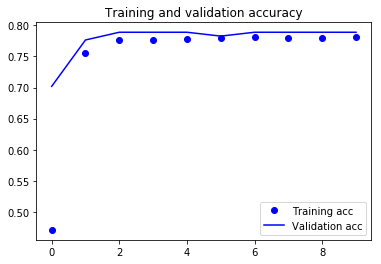

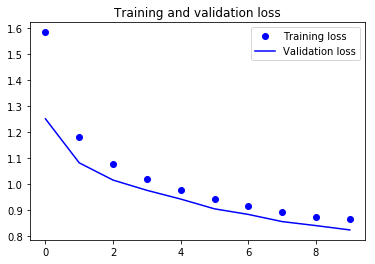

In [187]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### evaluation on X_test, y_test: 

In [193]:
loss,acc=model.evaluate() # to evaluate on validation_set 

NameError: name 'X_val' is not defined

In [190]:
loss

0.9220689143707503

In [192]:
acc # 77% accuracy without any tuning and overfitting reduction... :-) 

0.7661691554150178